# Summary:
This notebook will cover using **CountVectorizer** to convert texts to a matrix of token counts. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the count representation (sparse matrix) of texts.

# Table of contents
* [2. Machine learning models](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Text preprocessing](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 CountVectorizer](#Part2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1 LogisticRegression](#Part2.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1.1 validation_curve](#Part2.2.1.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1.2 GridSearchCV](#Part2.2.1.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1.3 Model evaluation](#Part2.2.1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.1.4 Feature importance](#Part2.2.1.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2 RandomForestClassifier](#Part2.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2.1 validation_curve](#Part2.2.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2.2 GridSearchCV](#Part2.2.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2.3 Model evaluation](#Part2.2.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.2.4 Feature importance](#Part2.2.2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3 XGBClassifier](#Part2.2.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3.1 validation_curve](#Part2.2.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3.2 GridSearchCV](#Part2.2.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3.3 Model evaluation](#Part2.2.3.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2.3.4 Feature importance](#Part2.2.3.4_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

Load preprocessed training files from the previous notebook.

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


<a id='Part2_link'></a>
# 2. Machine learning models

<a id='Part2.1_link'></a>
## 2.1 Text preprocessing

Based on EDA results from the previous notebook, custom_words, stopwords and punctuation will be removed from text.

To facilitate text tokenization, punctuation will be removed using `preprocess` function and the output text is saved in `text_clean` field.

In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [6]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

<a id='Part2.2_link'></a>
## 2.2 CountVectorizer

Based on the exploratory data analysis, some custom words such as `mutation` occur with a high frequency but provide limited information about each class. In addition, words such as `figure`, `data`, `table` also occur frequently in literature but cannot help with mutation classification. I generate a list of `stop_words` by combining classical 'stopwords' and some self-defined `custom_words` which will be removed when convert text documents to count vectors.

In [8]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”",
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433
print(len(stop_words))

433


CountVectorizer can convert text documents to token counts in the format of sparse matrix.

In [9]:
count_vectorizer=CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=stop_words, analyzer='word', min_df=3, preprocessor=None, max_features=None)
count_vectorizer.fit(bow_clean)
print('Total number of features in CountVectorizer: {}'.format(len(count_vectorizer.get_feature_names())))   ## 157815

Total number of features in CountVectorizer: 157815


In [10]:
train_vec = count_vectorizer.transform(train_df.text_clean)
print('train_vec.shape: {}'.format(train_vec.shape))

train_vec.shape: (3316, 157815)


<a id='Part2.2.1_link'></a>
### 2.2.1 LogisticRegression

<a id='Part2.2.1.1_link'></a>
### 2.2.1.1 validation_curve

1. **LogisticRegression** model hugely depends on data scaling. Before fitting the count vector directly to the LogisticRegression model, we can standardize features using **StandardScaler** from sklearn. In addition, since the count vector is a sparse matrix, `with_mean=False` needs to be specified. 

2. An important hyperparameter in LogisticRegression is 
<br>**C**: Inverse of regularization strength, smaller values specify stronger regularization.

3. To evaluate how model performs in both training and validation datasets, we can use **validation_curve** from sklearn to plot training and test scores for different values of a single hyperparameter. Here I will plot the training and test scores of **LogisticRegression** across different **C** values.

In [84]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1).values
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1).values
    test_mean = test_scores.mean(axis=1).values
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1).values
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

* Model: StandardScaler + LogisticRegression

In [ ]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_vec)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-3,3,12)
# c_vals=np.logspace(-5,3,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')

In [85]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_LogisticRegression_C_ss_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_LogisticRegression_C_ss_test_scores_df.csv'))
# c_vals=np.logspace(-3,3,12)

In [17]:
## Models were trained in HPC and output scores are uploaded here.
#train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_LogisticRegression_C2_ss_train_scores_df.csv'))
#test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_LogisticRegression_C2_ss_test_scores_df.csv'))

C: [1.00000000e-03 3.51119173e-03 1.23284674e-02 4.32876128e-02
 1.51991108e-01 5.33669923e-01 1.87381742e+00 6.57933225e+00
 2.31012970e+01 8.11130831e+01 2.84803587e+02 1.00000000e+03]
train_mean: [0.88283762 0.88442085 0.88540204 0.88570342 0.88773925 0.8884187
 0.88917316 0.88962604 0.88977682 0.89000309 0.89007862 0.89000309]
test_mean: [0.41361772 0.41271092 0.41391851 0.41210942 0.40308848 0.39673348
 0.38976697 0.38372267 0.3795053  0.37648265 0.38010361 0.37466697]
--------------------------------------------------------------------------------
C: 0.012328467394420659 achieves highest test score: 0.4139185124496424
--------------------------------------------------------------------------------


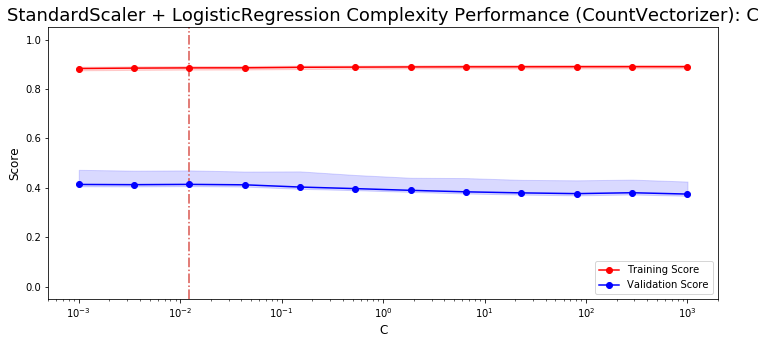

In [86]:
title='StandardScaler + LogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

Based on the training/validation curve of the LogisticRegression model, the training/validation accuracy doesn't fluctuate too much across different C values and C=0.0123 achieves the highest test score of 0.414.

To further finetune the best value for hyperparameter C, I will use **GridSearchCV** from sklearn.

<a id='Part2.2.1.2_link'></a>
### 2.2.1.2 GridSearchCV

Two hyperparameters will be tested in **GridSearchCV** from sklearn to find the best values for **LogisticRegression**:
1. **C**: Inverse of regularization strength, smaller values specify stronger regularization.
2. **class_weight**: Since the 9 classes in the training dataset is not balanced. To avoid bias in model training, class_weight may need to be added to the model.

* Model: StandardScaler + LogisticRegression

In [19]:
pl = Pipeline([('ss', StandardScaler(with_mean=False)),
               ('lr', LogisticRegression(n_jobs=-1,random_state=8))])

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_CountVectorizer_LogisticRegression_ss_gridsearch1.py
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"lr__C":[0.001,0.002,0.005,0.01,0.02,0.03],
        "lr__class_weight":[None,{1:1,2:1,3:2,4:1,5:2,6:2,7:1,8:2,9:2}]}
clf=GridSearchCV(pl, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)
pd.DataFrame.from_dict(clf.cv_results_).to_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_LogisticRegression_ss_gridsearch1.csv'),index=False)

In [25]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_LogisticRegression_ss_gridsearch1.csv'))
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,43.679911,1.431772,0.094299,0.005436,0.001,NaN,"{'lr__C': 0.001, 'lr__class_weight': None}",0.377246,0.316817,0.342900,...,0.381484,0.056976,1,0.873112,0.887547,0.891861,0.878343,0.883327,0.882838,0.006613
1,46.066793,1.360057,0.095328,0.007159,0.001,"{1: 1, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 1, 8: ...","{'lr__C': 0.001, 'lr__class_weight': {1: 1, 2:...",0.380240,0.310811,0.338369,...,0.378166,0.056287,2,0.875000,0.887925,0.892238,0.877966,0.881445,0.882915,0.006345
2,54.989449,2.236858,0.101218,0.006321,0.002,NaN,"{'lr__C': 0.002, 'lr__class_weight': None}",0.366766,0.318318,0.339879,...,0.377865,0.054669,3,0.873867,0.888302,0.892238,0.877966,0.884833,0.883441,0.006702
3,58.107061,1.568050,0.099560,0.008389,0.002,"{1: 1, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 1, 8: ...","{'lr__C': 0.002, 'lr__class_weight': {1: 1, 2:...",0.365269,0.312312,0.338369,...,0.374849,0.055560,6,0.875755,0.887925,0.892238,0.877966,0.881822,0.883141,0.006143
4,74.125806,1.247863,0.095744,0.006606,0.005,NaN,"{'lr__C': 0.005, 'lr__class_weight': None}",0.368263,0.307808,0.347432,...,0.375754,0.053444,5,0.876133,0.890189,0.892992,0.879473,0.885962,0.884950,0.006338


In [ ]:
print("lr__C: {}".format(clf.best_estimator_.get_params()['lr__C']))
print("lr__class_weight: {}".format(clf.best_estimator_.get_params()['lr__class_weight']))

lr__C: 0.001
<br>lr__class_weight: None

<a id='Part2.2.1.3_link'></a>
### 2.2.1.3 Model evaluation

Here are some functions used in model evaluation.

In [26]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [27]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [35]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [36]:
def plot_ROC_curve(acc_df):
    probas=np.array(acc_df.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

* Model: StandardScaler + LogisticRegression(C=0.001)

In [30]:
X=train_vec
y=train_df.Class.values

pl = Pipeline([('ss', StandardScaler(with_mean=False)),
               ('lr', LogisticRegression(C=0.001,n_jobs=-1,random_state=8))])

In [31]:
output=model_eval(pl, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.8s remaining:  1.1min


accuracy score: 0.38148371531966224
log_loss: 2.6548202235513783


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.0s finished


In [32]:
output.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,pred
0,0.076097,0.060722,0.007338,0.117114,0.006793,0.007801,0.713777,0.004971,0.005388,7
1,0.069930,0.080455,0.021718,0.456413,0.027009,0.050971,0.255811,0.018115,0.019579,4
2,0.069930,0.080455,0.021718,0.456413,0.027009,0.050971,0.255811,0.018115,0.019579,4
3,0.149022,0.105669,0.022724,0.097157,0.034764,0.034067,0.516566,0.018364,0.021668,7
4,0.207140,0.081547,0.036901,0.218879,0.048119,0.080143,0.291002,0.017000,0.019269,7


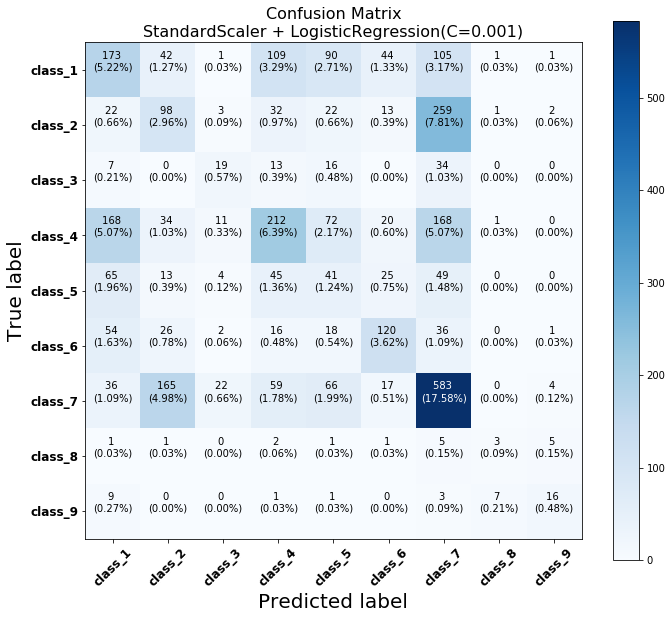

In [33]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nStandardScaler + LogisticRegression(C=0.001)', cmap=plt.cm.Blues)

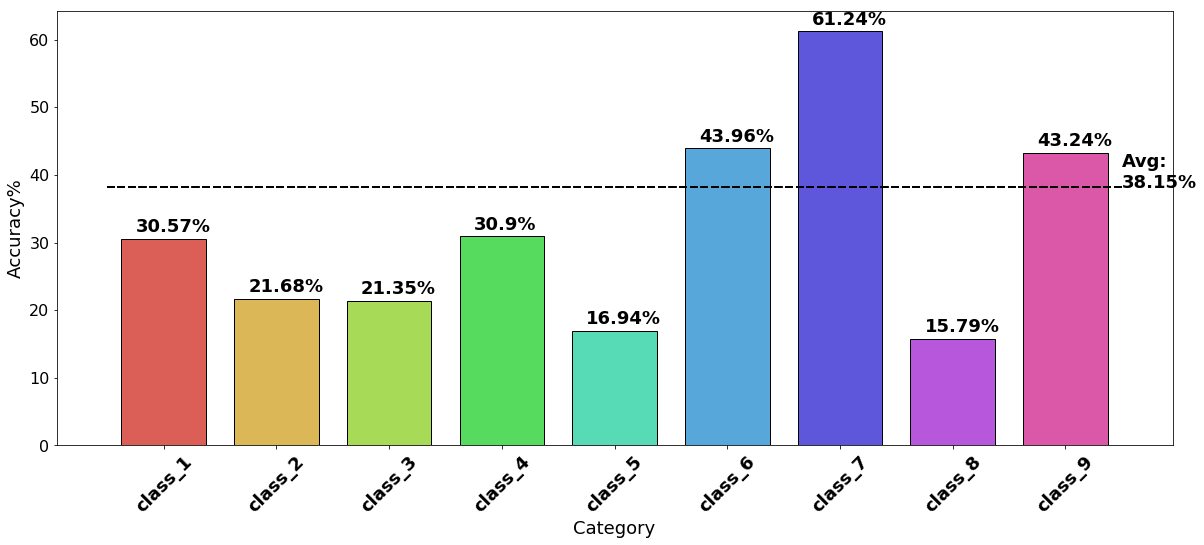

In [38]:
plot_acc_bar(cm,total_acc=38.15)

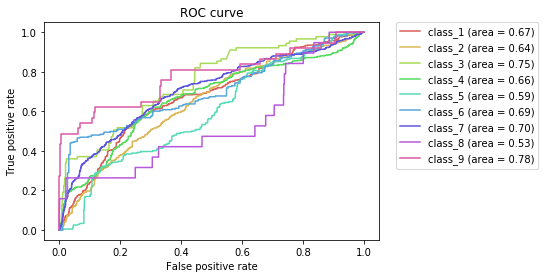

In [39]:
plot_ROC_curve(output)

<a id='Part2.2.1.4_link'></a>
### 2.2.1.4 Feature importance

We can extract the features (words) with highest/smallest coefficients from the trained model for each class.

In [40]:
def extract_feature_importance(model, vectorizer,num):
    '''
    Extract features with largest/smallest coefs from the 
    trained model based on vectorizer for each class
    '''
    index_to_word={v:k for k,v in vectorizer.vocabulary_.items()}
    output={}
    for idx in range(model.coef_.shape[0]):
        output[idx]={}
        word_importances=[(v,index_to_word[i]) for i,v in enumerate(model.coef_[idx])]
        word_importances_sorted=sorted(word_importances,key=lambda x:x[0],reverse=True)
        tops=word_importances_sorted[:num]
        bottoms=word_importances_sorted[-num:]
        output[idx]=tops+bottoms
    return output

In [41]:
def plot_feature_importance(feature_df,num):
    palette=sns.color_palette('RdBu',20)
    fig,axes=plt.subplots(3,3,figsize=(12,12))
    for i in range(len(output)):
        nrow=i//3
        ncol=i%3
        data_df=pd.DataFrame.from_records(output[i],columns=['coef','words'])
        sns.barplot(x='words',y='coef',data=data_df,palette=palette,ax=axes[nrow][ncol],edgecolor='black')
        axes[nrow][ncol].set_title('Class{}'.format(i+1))
        axes[nrow][ncol].set_xticklabels(np.array(data_df.words),rotation=90)
    plt.tight_layout()

* Model: StandardScaler + LogisticRegression(C=0.001)

In [48]:
ss=StandardScaler(with_mean=False)
X=ss.fit_transform(train_vec)
y=train_df.Class.values
clf=LogisticRegression(C=0.001,n_jobs=-1,random_state=8)
clf.fit(X,y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=8,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

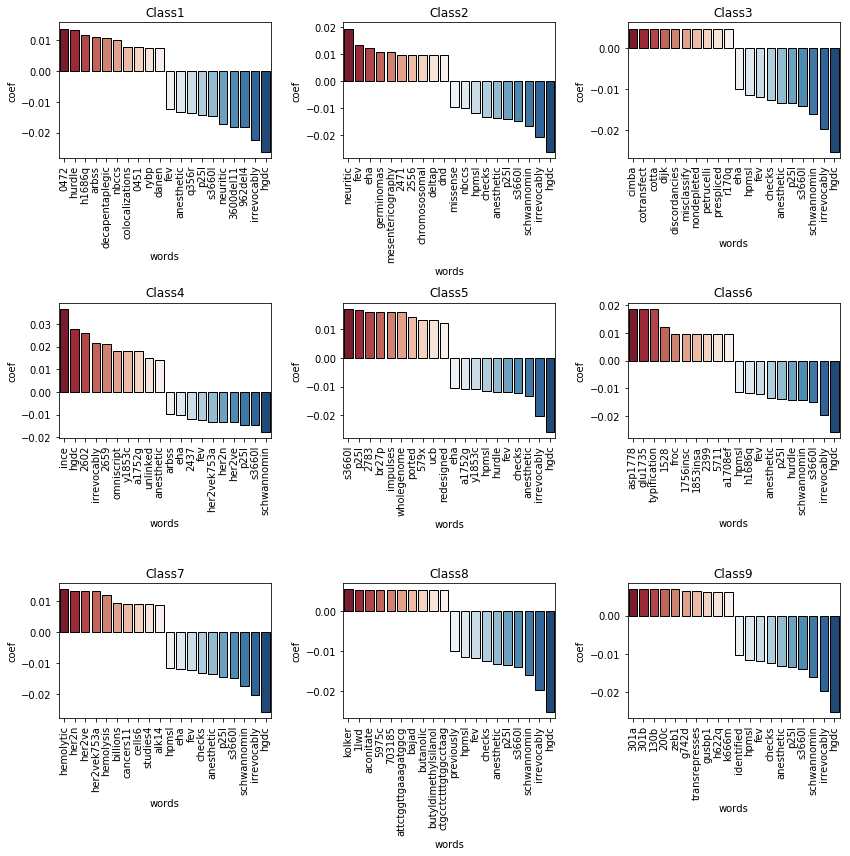

In [47]:
output=extract_feature_importance(clf, count_vectorizer,num=10)
plot_feature_importance(output,num=10)

**Conclusion for LogisticRegression**: 
<br>StandardScaler + LogisticRegression(C=0.001) achieves the highest accuracy score of 0.38. There is overall overfitting using this model.

<a id='Part2.2.2_link'></a>
### 2.2.2 RandomForestClassifier

<a id='Part2.2.2.1_link'></a>
### 2.2.2.1 validation_curve

Several important hyperparameters for **RandomForestClassifier**:
1. **n_estimators** (default=100): The number of trees in the forest.
2. **max_depth** (default=None): The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
3. **min_samples_leaf** (default=1): The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

* Model: RandomForestClassifier

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
n_estimators=np.array([100,150,200,500,1000,2000])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'n_estimators', param_range = n_estimators, cv = cv, scoring = 'accuracy')

In [87]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_CountVectorizer_RandomForestClassifier_nestimators.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_nestimators_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_nestimators_test_scores_df.csv'))

n_estimators: [ 100  150  200  500 1000 2000]
train_mean: [0.90335005 0.90335005 0.90335005 0.90335005 0.90335005 0.90335005]
test_mean: [0.45492942 0.46006174 0.4597787  0.46547409 0.46457049 0.4678952 ]
--------------------------------------------------------------------------------
n_estimators: 2000 achieves highest test score: 0.46789520343639024
--------------------------------------------------------------------------------


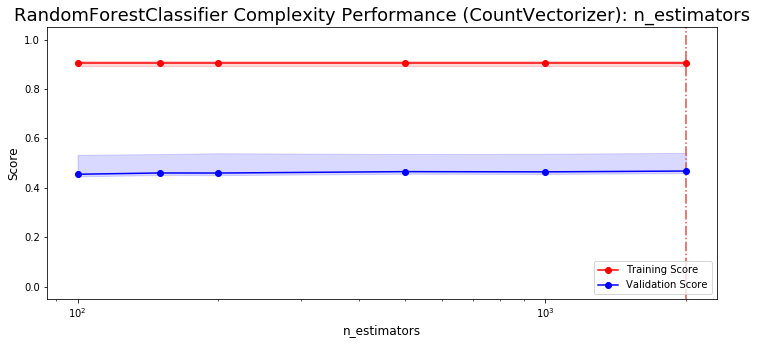

In [88]:
n_estimators=np.array([100,150,200,500,1000,2000])
title='RandomForestClassifier Complexity Performance (CountVectorizer): n_estimators'
plot_val_curve(train_scores,test_scores,'n_estimators', n_estimators,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([5,10,20,50,100,500,1000,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')

In [89]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_maxdepth_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_maxdepth_test_scores_df.csv'))

max_depth: [    5    10    20    50   100   500  1000 10000]
train_mean: [0.5049715  0.68719602 0.85871514 0.89784664 0.89754484 0.89754484
 0.89754484 0.89754484]
test_mean: [0.38019954 0.42238337 0.43949822 0.40936581 0.40606422 0.40606422
 0.40606422 0.40606422]
--------------------------------------------------------------------------------
max_depth: 20 achieves highest test score: 0.43949822284632634
--------------------------------------------------------------------------------


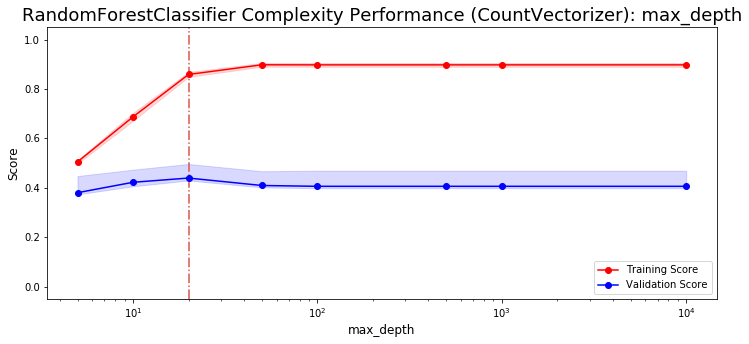

In [90]:
max_depth=np.array([5,10,20,50,100,500,1000,10000])
title='RandomForestClassifier Complexity Performance (CountVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')

In [91]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_minsamplesleaf_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_RandomForestClassifier_minsamplesleaf_test_scores_df.csv'))

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89754484 0.78114255 0.65666448 0.47295193 0.35252939 0.30209673]
test_mean: [0.40606422 0.44488455 0.43711547 0.36976081 0.32992248 0.30010042]
--------------------------------------------------------------------------------
min_samples_leaf: 5 achieves highest test score: 0.4448845529634376
--------------------------------------------------------------------------------


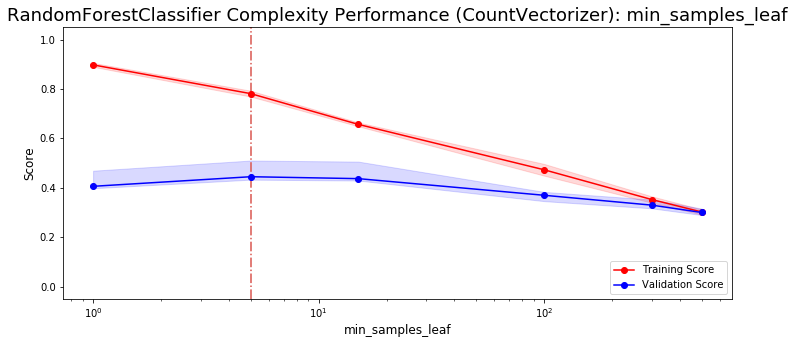

In [92]:
min_samples_leaf=np.array([1,5,15,100,300,500])
title='RandomForestClassifier Complexity Performance (CountVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

**Conclusion**:
1. **n_estimators** (default=100): The number of trees in the forest generally doesn't affect training/validation score.
2. **max_depth** (default=None): The maximum depth of the tree. Larger max_depth leads to increased training score and overfitting.
3. **min_samples_leaf** (default=1): The minimum number of samples required to be at a leaf node. Smaller min_samples_leaf leads to increased training score and overfitting.

<a id='Part2.2.2.2_link'></a>
### 2.2.2.2 GridSearchCV

To further finetune the best values for hyperparameters, I will use **GridSearchCV** from sklearn.

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_CountVectorizer_RandomForestClassifier_gridsearch1.py
rf=RandomForestClassifier(n_jobs=-1,random_state=8)
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"n_estimators":[200,500,1000],
        "max_depth":[5,10,20,None],
        "min_samples_leaf":[1,5,15]}
clf=GridSearchCV(rf, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)
pd.DataFrame.from_dict(clf.cv_results_).to_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_RandomForestClassifier_gridsearch1.csv'),index=False)

In [254]:
print("n_estimators: {}".format(clf.best_estimator_.get_params()['n_estimators']))
print("max_depth: {}".format(clf.best_estimator_.get_params()['max_depth']))
print("min_samples_leaf: {}".format(clf.best_estimator_.get_params()['min_samples_leaf']))

n_estimators: 1000
<br>max_depth: None
<br>min_samples_leaf: 5

In [114]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_RandomForestClassifier_gridsearch1.csv'))
cv_results[(cv_results.param_n_estimators==1000) & (cv_results.param_min_samples_leaf==5)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
5,8.475933,1.208022,7.815563,0.670422,5.0,5,1000,"{'max_depth': 5, 'min_samples_leaf': 5, 'n_est...",0.287425,0.330330,...,0.375151,0.078020,36,0.482251,0.483396,0.495479,0.526177,0.517877,0.501036,0.017948
14,34.055305,3.594774,7.947143,0.879036,10.0,5,1000,"{'max_depth': 10, 'min_samples_leaf': 5, 'n_es...",0.366766,0.408408,...,0.441797,0.077413,20,0.644260,0.683019,0.679352,0.683239,0.667670,0.671508,0.014757
23,71.980351,8.085163,7.785498,0.921239,20.0,5,1000,"{'max_depth': 20, 'min_samples_leaf': 5, 'n_es...",0.419162,0.430931,...,0.469843,0.063651,4,0.789653,0.810189,0.801055,0.796234,0.797140,0.798854,0.006750
32,82.537277,9.080566,7.730789,0.448287,NaN,5,1000,"{'max_depth': None, 'min_samples_leaf': 5, 'n_...",0.444611,0.442943,...,0.474668,0.059135,1,0.820619,0.828679,0.823662,0.814313,0.820098,0.821474,0.004703


<a id='Part2.2.2.3_link'></a>
### 2.2.2.3 Model evaluation

* Model: RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_leaf=5)

In [117]:
X=train_vec
y=train_df.Class.values
clf=RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_leaf=5,n_jobs=-1,random_state=8)

In [118]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min


accuracy score: 0.4746682750301568
log_loss: 1.5534122694577313


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [123]:
output.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,pred
0,0.200647,0.124049,0.014943,0.271931,0.042396,0.037518,0.283242,0.010036,0.015237,7
1,0.176561,0.167440,0.013847,0.175709,0.041137,0.033062,0.371645,0.008939,0.011661,7
2,0.176561,0.167440,0.013847,0.175709,0.041137,0.033062,0.371645,0.008939,0.011661,7
3,0.146689,0.195126,0.013885,0.135971,0.043459,0.035752,0.405887,0.009095,0.014137,7
4,0.175874,0.139391,0.018690,0.222329,0.059570,0.050703,0.305351,0.009061,0.019031,7


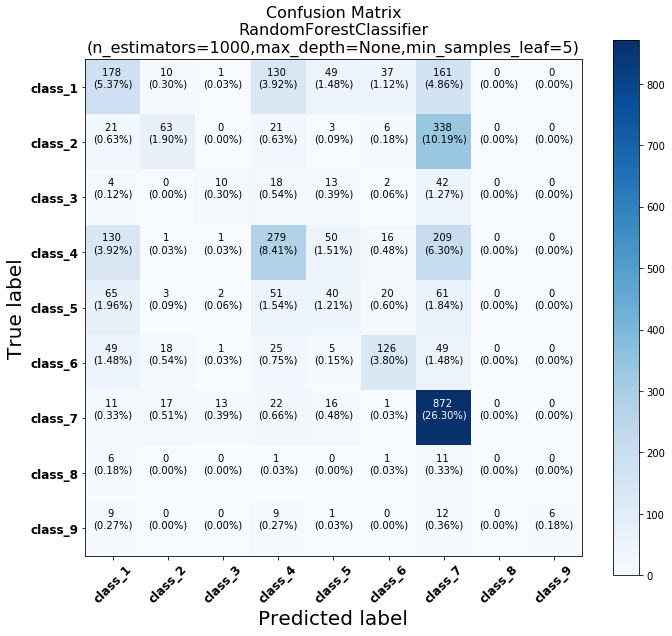

In [120]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nRandomForestClassifier\n(n_estimators=1000,max_depth=None,min_samples_leaf=5)', cmap=plt.cm.Blues)

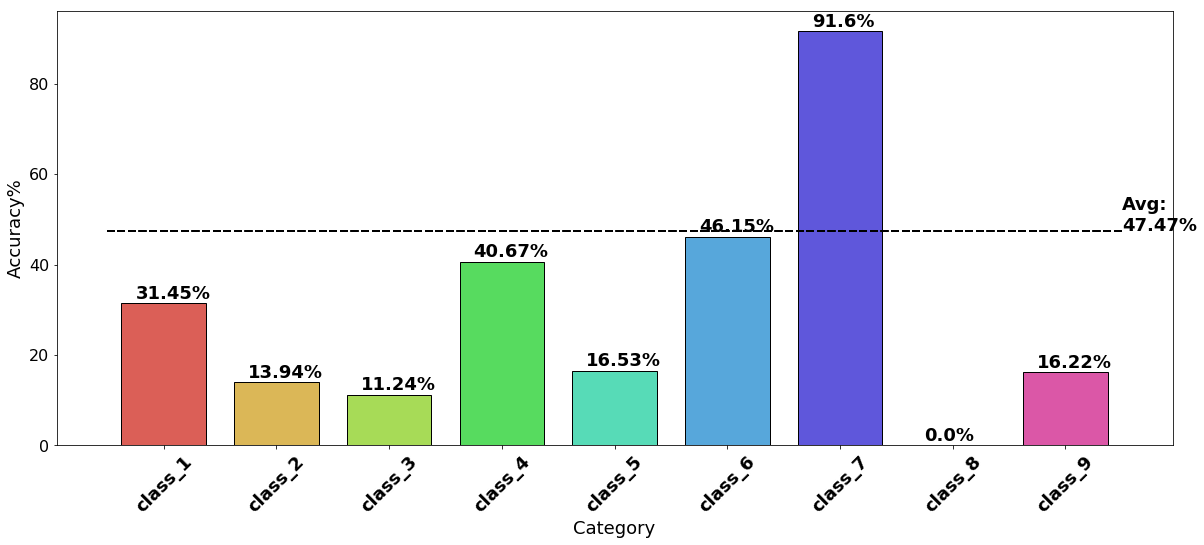

In [121]:
plot_acc_bar(cm,total_acc=47.47)

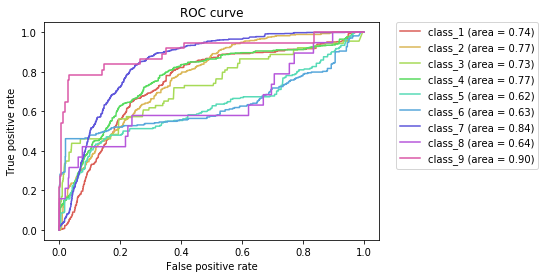

In [122]:
plot_ROC_curve(output)

<a id='Part2.2.2.4_link'></a>
### 2.2.2.4 Feature importance

We can extract the features (words) with high importance from the trained model.

* Model: RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_leaf=5)

In [124]:
X=train_vec
y=train_df.Class.values
clf=RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_leaf=5,n_jobs=-1,random_state=8)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [125]:
def extract_feature_importance_rf(model, vectorizer, n=20):
    '''
    Extract features with high importance from the trained model based on vectorizer
    '''
    index_to_word={v:k for k,v in vectorizer.vocabulary_.items()}
    word_importances=[(index_to_word[i], v) for i,v in enumerate(model.feature_importances_)]
    word_importances_sorted=sorted(word_importances,key=lambda x:x[1],reverse=True)
    tops=word_importances_sorted[:10]
    output=pd.DataFrame.from_records(tops,columns=['words','importance'])
    return output

In [127]:
top_features=extract_feature_importance_rf(clf,count_vectorizer,n=20)
top_features

,words,importance
0,kinase,0.003757
1,activation,0.003072
2,inhibitors,0.003012
3,missense,0.002777
4,activating,0.002776
5,tyrosine,0.002549
6,treatment,0.002444
7,activated,0.002437
8,phosphorylation,0.002384
9,suppressor,0.002234


**Conclusion for RandomForestClassifier**: 
<br>RandomForestClassifier(n_estimators=1000,max_depth=None,min_samples_leaf=5) achieves the highest accuracy score of 0.47.

<a id='Part2.2.3_link'></a>
### 2.2.3 XGBClassifier

<a id='Part2.2.3.1_link'></a>
### 2.2.3.1 validation_curve

https://xgboost.readthedocs.io/en/latest/parameter.html
<br>Important hyperparameters for **XGBClassifier**:
1. **eta** (learning_rate, default=0.3)
2. **gamma** (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
3. **max_depth** (default=6): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
4. **min_child_weight** (default=1): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
5. **colsample_bytree** (default=1): The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

* Model: XGBClassifier

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([5,6,10,20,50,100,500,1000])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')

In [93]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_CountVectorizer_XGBClassifier_maxdepth.py
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_maxdepth_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_maxdepth_test_scores_df.csv'))

max_depth: [   5    6   10   20   50  100  500 1000]
train_mean: [0.90214401 0.90289779 0.90335005 0.90335005 0.90335005 0.90335005
 0.90335005 0.90335005]
test_mean: [0.47896498 0.48346417 0.46873807 0.46751643 0.46209503 0.46209503
 0.46209503 0.46209503]
--------------------------------------------------------------------------------
max_depth: 6 achieves highest test score: 0.48346416810402604
--------------------------------------------------------------------------------


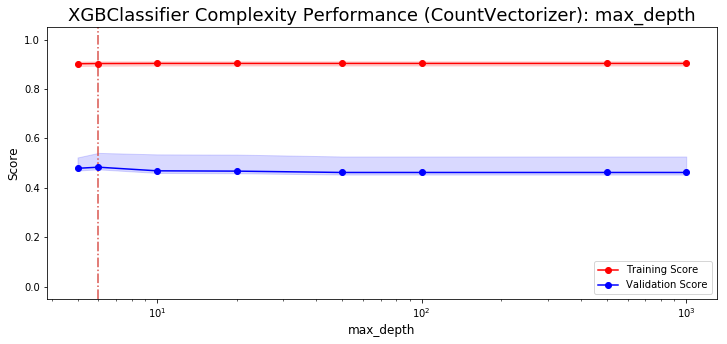

In [94]:
max_depth=np.array([5,6,10,20,50,100,500,1000])
title='XGBClassifier Complexity Performance (CountVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')

In [95]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_minchildweight_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_minchildweight_test_scores_df.csv'))

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.86459873 0.85917065 0.8541952  0.84869241 0.84469679 0.82954007]
test_mean: [0.49163857 0.47776004 0.47926832 0.49343759 0.49521256 0.48346814]
--------------------------------------------------------------------------------
min_child_weight: 10 achieves highest test score: 0.49521256074996767
--------------------------------------------------------------------------------


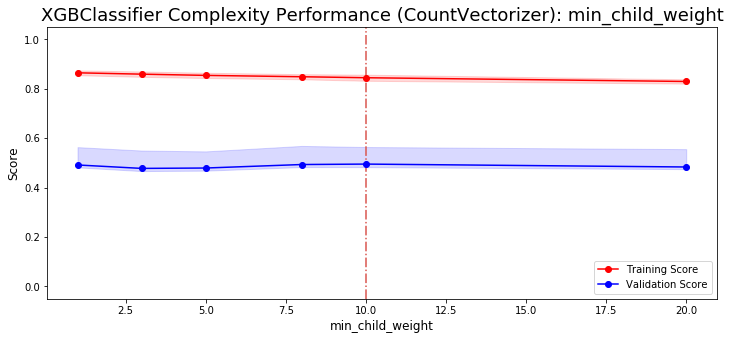

In [97]:
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
title='XGBClassifier Complexity Performance (CountVectorizer): min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
eta=np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'eta', param_range = eta, cv = cv, scoring = 'accuracy')

In [98]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_eta_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_eta_test_scores_df.csv'))

eta: [0.05 0.1  0.15 0.2  0.25 0.3 ]
train_mean: [0.86459873 0.86459873 0.86459873 0.86459873 0.86459873 0.86459873]
test_mean: [0.49163857 0.49163857 0.49163857 0.49163857 0.49163857 0.49163857]
--------------------------------------------------------------------------------
eta: 0.05 achieves highest test score: 0.4916385679532471
--------------------------------------------------------------------------------


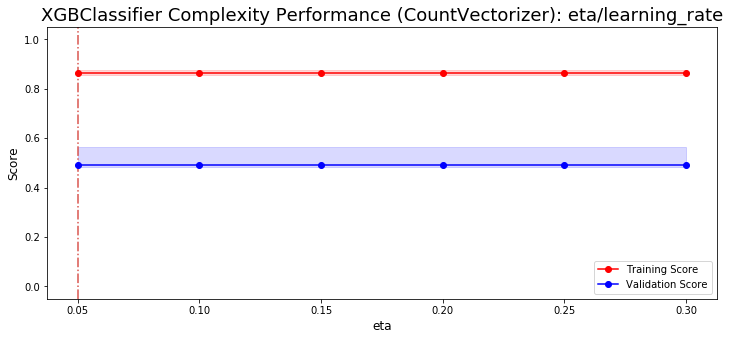

In [99]:
eta=np.array([0.05, 0.10, 0.15, 0.20, 0.25, 0.30])
title='XGBClassifier Complexity Performance (CountVectorizer): eta/learning_rate'
plot_val_curve(train_scores,test_scores,'eta', eta,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
gamma=np.array([0.0, 0.1, 0.2 , 0.3, 0.4])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'gamma', param_range = gamma, cv = cv, scoring = 'accuracy')

In [100]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_gamma_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_gamma_test_scores_df.csv'))

gamma: [0.  0.1 0.2 0.3 0.4]
train_mean: [0.86459873 0.86339369 0.86437297 0.86482492 0.8642212 ]
test_mean: [0.49163857 0.48619675 0.48951009 0.49344033 0.49552837]
--------------------------------------------------------------------------------
gamma: 0.4 achieves highest test score: 0.4955283707586081
--------------------------------------------------------------------------------


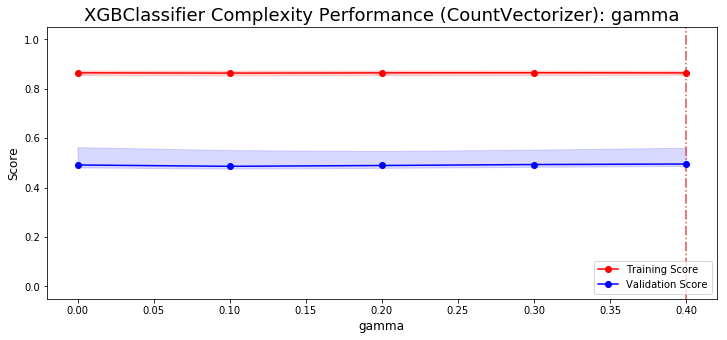

In [101]:
gamma=np.array([0.0, 0.1, 0.2 , 0.3, 0.4])
title='XGBClassifier Complexity Performance (CountVectorizer): gamma'
plot_val_curve(train_scores,test_scores,'gamma', gamma,title,logx=False)

In [ ]:
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')

In [102]:
## Models were trained in HPC and output scores are uploaded here.
train_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_colsamplebytree_train_scores_df.csv'))
test_scores=pd.read_csv(os.path.join(base_dir,'ml_result/Personalized_Medicine_CountVectorizer_XGBClassifier_colsamplebytree_test_scores_df.csv'))

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.85623126 0.85788914 0.8638441  0.8627898  0.86459873]
test_mean: [0.49848958 0.49729527 0.48316567 0.48827897 0.49163857]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.4984895779442439
--------------------------------------------------------------------------------


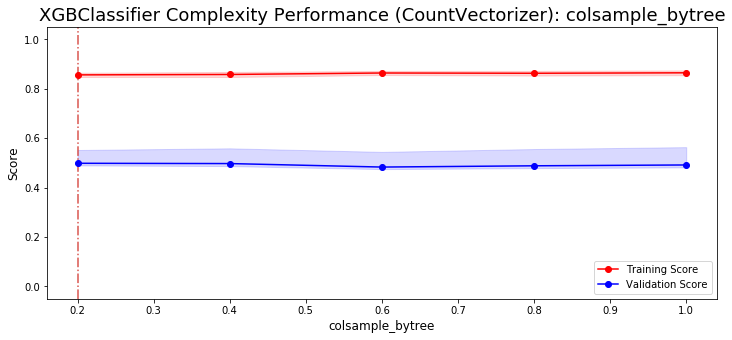

In [103]:
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
title='XGBClassifier Complexity Performance (CountVectorizer): colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

**Conclusion**:
1. The overall validation accuracy is higher using XGBClassifier.
2. XGBClassifier performance is not affected by hyperparameters tested here.

<a id='Part2.2.3.2_link'></a>
### 2.2.3.2 GridSearchCV

To further finetune the best values for hyperparameters, I will use **GridSearchCV** from sklearn.

In [ ]:
## Models were trained in HPC and output scores are uploaded here.
## Personalized_Medicine_CountVectorizer_XGBClassifier_gridsearch1.py
xgb=XGBClassifier()
X=train_vec
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
params={"eta":[0.05, 0.20, 0.30],
        "max_depth":[6],
        "min_child_weight":[ 1, 5, 10 ],
        "gamma":[0.0, 0.2, 0.4],
        "colsample_bytree":[0.2, 0.6, 1.0]}
clf=GridSearchCV(xgb, param_grid=params, cv=cv, scoring = 'accuracy',return_train_score=True)
clf.fit(X, y)
pd.DataFrame.from_dict(clf.cv_results_).to_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_XGBClassifier_gridsearch1.csv'),index=False)

In [ ]:
print("eta: {}".format(clf.best_estimator_.get_params()['eta']))
print("max_depth: {}".format(clf.best_estimator_.get_params()['max_depth']))
print("min_child_weight: {}".format(clf.best_estimator_.get_params()['min_child_weight']))
print("gamma: {}".format(clf.best_estimator_.get_params()['gamma']))
print("colsample_bytree: {}".format(clf.best_estimator_.get_params()['colsample_bytree']))

eta: 0.05
<br>max_depth: 6
<br>min_child_weight: 10
<br>gamma: 0.0
<br>colsample_bytree: 0.6

In [128]:
cv_results=pd.read_csv(os.path.join(base_dir,'ml_result3/Personalized_Medicine_CountVectorizer_XGBClassifier_gridsearch1.csv'))
cv_results[(cv_results.param_eta==0.05) & (cv_results.param_max_depth==6) & (cv_results.param_min_child_weight==10)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_eta,param_gamma,param_max_depth,param_min_child_weight,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,193.051273,1.355894,0.511836,0.016260,0.2,0.05,0.0,6,10,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.490651,0.047056,13,0.893505,0.907547,0.908440,0.889266,0.891983,0.898148,0.008158
5,193.043958,2.267919,0.516741,0.016817,0.2,0.05,0.2,6,10,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.488239,0.047486,34,0.893127,0.906792,0.908063,0.889266,0.891983,0.897846,0.007933
8,190.778780,1.470111,0.506494,0.019639,0.2,0.05,0.4,6,10,"{'colsample_bytree': 0.2, 'eta': 0.05, 'gamma'...",...,0.489445,0.052220,22,0.892749,0.907170,0.908063,0.889642,0.891983,0.897922,0.007987
29,530.780124,3.522242,0.501707,0.025044,0.6,0.05,0.0,6,10,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.498492,0.053152,1,0.895015,0.908679,0.909570,0.890772,0.892360,0.899279,0.008157
32,531.541905,2.789462,0.503679,0.018187,0.6,0.05,0.2,6,10,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.480398,0.051527,73,0.895393,0.907925,0.909947,0.890772,0.892736,0.899355,0.007985
35,533.518832,5.602375,0.501504,0.017460,0.6,0.05,0.4,6,10,"{'colsample_bytree': 0.6, 'eta': 0.05, 'gamma'...",...,0.492762,0.041368,10,0.893882,0.907925,0.909194,0.890019,0.892360,0.898676,0.008173
56,841.156959,4.281839,0.505156,0.018635,1.0,0.05,0.0,6,10,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.481303,0.057943,67,0.895770,0.908302,0.910324,0.891149,0.893113,0.899732,0.007985
59,868.702705,9.895199,0.513217,0.019719,1.0,0.05,0.2,6,10,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.489445,0.058633,22,0.895015,0.908302,0.909947,0.890772,0.892360,0.899279,0.008169
62,834.545879,8.797951,0.510344,0.037033,1.0,0.05,0.4,6,10,"{'colsample_bytree': 1.0, 'eta': 0.05, 'gamma'...",...,0.488239,0.052801,34,0.894637,0.908679,0.909947,0.891525,0.892360,0.899430,0.008144


<a id='Part2.2.3.3_link'></a>
### 2.2.3.3 Model evaluation

* Model: XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6)

In [130]:
X=train_vec
y=train_df.Class.values
clf=XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6,n_jobs=-1,random_state=8)

In [131]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 16.0min remaining: 24.0min


accuracy score: 0.48492159227985526
log_loss: 1.5876597159742114


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.1min finished


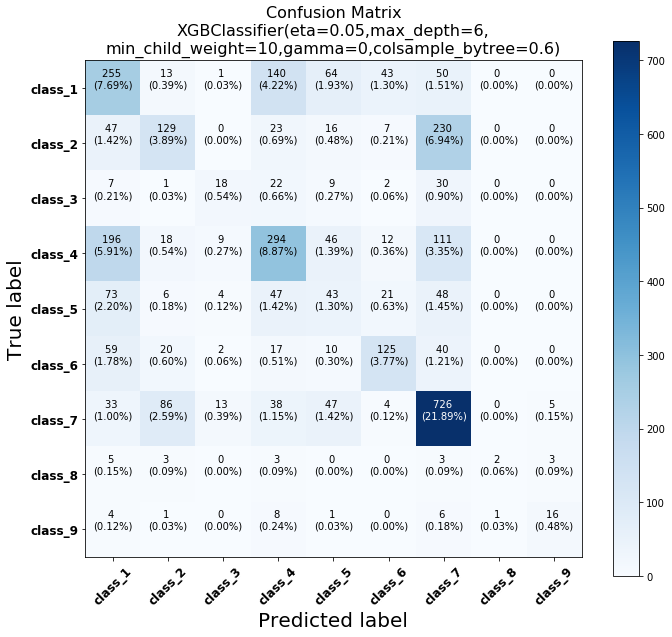

In [133]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nXGBClassifier(eta=0.05,max_depth=6,\nmin_child_weight=10,gamma=0,colsample_bytree=0.6)', cmap=plt.cm.Blues)

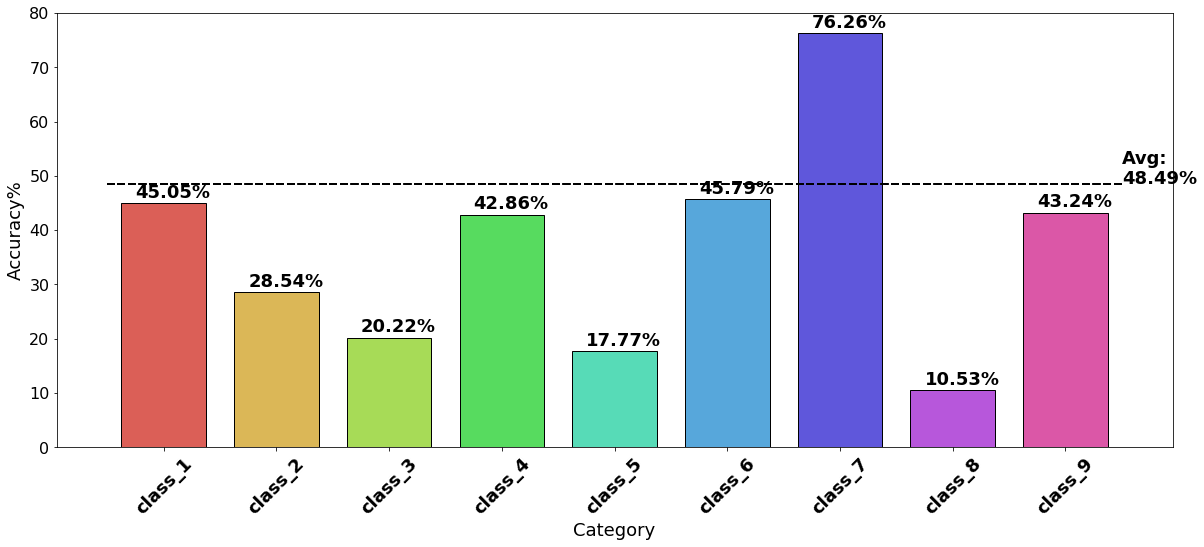

In [134]:
plot_acc_bar(cm,total_acc=48.49)

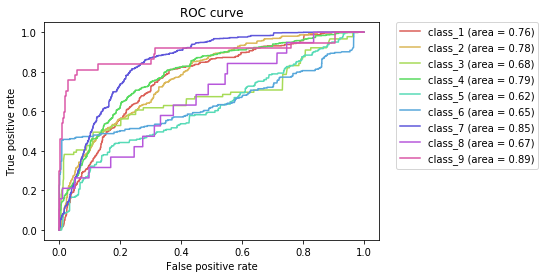

In [135]:
plot_ROC_curve(output)

<a id='Part2.2.3.4_link'></a>
### 2.2.3.4 Feature importance

We can extract the features (words) with high importance from the trained model.

* Model: XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6)

In [136]:
X=train_vec
y=train_df.Class.values
clf=XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6,n_jobs=-1,random_state=8)
clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.6, eta=0.05, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=10, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='multi:softprob', random_state=8, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [137]:
top_features=extract_feature_importance_rf(clf,count_vectorizer,n=20)
top_features

,words,importance
0,y105c,0.022025
1,fanconi,0.013933
2,neutrality,0.013401
3,histopathology,0.009632
4,phosphoinositide,0.008818
5,nhgri,0.008243
6,ub,0.008183
7,unclassified,0.007059
8,substituted,0.006340
9,pten,0.006066


**Conclusion for XGBClassifier**: 
<br>XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6) achieves the highest accuracy score of 0.48.

## Conclusion for CountVectorizer:

1. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** applied to **CountVectorizer** cannot achieve accuracy above 0.50.
2. **RandomForestClassifier** and **XGBClassifier** achieve comparable training performance and the accuracy score is higher than **LogisticRegression**.
3. XGBClassifier(eta=0.05,max_depth=6,min_child_weight=10,gamma=0,colsample_bytree=0.6) achieves the highest accuracy score of 0.48.